# Example for the `Speech-To-Text (STT)` API

This API allows you to easily perform prediction / search on audios / videos by  automatically loading models and calling associated function. 

You can identify models either by their name or by their associated language. To associate a model to a language, go to `models/stt/__init__.py` in the `_pretrained` variables (at the end of the file) you can see `'en' : 'whisper'`. It means that when you are calling a function with `lang = 'en'`, it will load the `whisper` model to perform prediction. 

Do not forget to initialize `whisper` ! (cf cell below)

Note : prediction / search can be performed either on audios, either on videos !

## Build whisper

[Whisper](https://github.com/openai/whisper) is a multilingual `Speech-to-Text` model trained by `OpenAI`.

**WARNING** : `pytorch` is required to convert the weigths, as the official project is made with `pytorch`. Do not forget to install it : `pip install torch`. A GPU version is **not** required ;)

**Important Note** : the tokenizer is now copied from the `transformers` library, as the new official `openai`'s code is using their custom `tiktoken` tokenizer. This means that the 2 tokenizers are not *exactly* identical, but are compatible as the differences do not have any impact on the model

In [3]:
from models.stt import Whisper

model = Whisper(pretrained = 'base', lang = 'multi', nom = 'whisper')
print(model)


========== whisper ==========
Sub model stt_model
- Inputs 	: unknown
- Outputs 	: unknown
- Number of layers 	: 2
- Number of parameters 	: 72.594 Millions
- Model not compiled

Transfer-learning from : base
Already trained on 0 epochs (0 steps)

- Language : multi
- Vocabulary (size = 50364) : ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ...]
- Audio rate : 16000
- # mel channels : 80
- Use CTC decoder : False



## Prediction API

The prediction API is very simple to use : pass the audio filename(s), and the model you want (or the audio language) and that's it !

The prediction splits the audio by *frames* of a given amount of time (default to 30sec), and predicts the text for each frame. Then it concatenates all the texts to build the complete transcription of the audio file ! Note that `Whisper` also splits each *frame* into sub-frames that are given in the output of the function. This may be useful to search a span of text, or even complete / correct the transcription ! 

This demonstration is performed on a short and clean audio. Nevertheless, `Whisper` has been trained on large scale datasets, and is able to transcribe audios in many languages, even in noisy or low quality audios !

**[NEW]** The inference method of `Whisper` is now compatible with the [XLA](https://www.tensorflow.org/xla) optimization ! This makes the model much faster than in eager (sequential) model, at the cost of a much slower 1st call, as it needs to compute the execution graph. If you want to run in eager mode, pass `run_eagerly = True`, or `use_xla = False` to use the graph mode without XLA optimization (see the `CHANGELOG` for more details)

In [6]:
from loggers import set_level
from models.stt import predict
from utils.audio import display_audio

set_level('time')

filename = 'audio_en.wav'
pred = predict(filename, model = 'whisper', overwrite = True, save = False)

#display_audio(filename)
pred

Timers for logger timer :
- predict : 496 ms
  - initialization : 0 μs
  - pre_processing : 0 μs
  - loading audio : 119 ms
  - segment processing : 10 ms
  - detect_language : 314 ms
    - pre_processing : 12 ms
    - language detection : 33 ms
  - inference : 50 ms
    - Transformer inference : 50 ms
  - post_processing : 0 μs


[('audio_en.wav',
  {'filename': 'audio_en.wav',
   'text': 'The streets were narrow and unpaid but very fairly clean.',
   'alignment': [{'id': -1,
     'start': 0.0,
     'end': 4.0,
     'num': 0,
     'time': 4.0,
     'text': 'The streets were narrow and unpaid but very fairly clean.',
     'tokens': array([  440,  8481,   645,  9432,   293,   517, 35035,   457,   588,
             6457,  2541,    13]),
     'score': 0}]})]

## Search keyword in audio

The `search` function allows you to search a keyword in an audio / video and get all timestamps where this keyword has been found (with a given probability threshold). As the model is relatively poor for *transcription*, I use **partial alignment** to get the probability of the word at each position (cf README.md for explaination on partial alignment). 

Next, to find the approximately timestamp where the word has been pronounced, I get the start of the *frame* (as audio are splitted in frames of *n* sec) and get the relative position of the word in the frame's text. 

In the below example, the *unpaved* word seems to be approximately in themiddle of the text so I suggest it is approximately at themiddle of the audio : the estimated timestamp is at 1.9sec which is approximately the middle of the 4sec audio !

In this case the estimation is quite good as the frame is short (4sec) but this estimation is worst when audios are longer (with 30sec frame by default). It is the reason why, when displaying audio timestamps, I have added the `before` argument which wil display audio *n* sec before the predicted timestamp (by default to 2.5sec but you can increase it to 5 or 7.5sec if audios are longer / sparse (with silences)). 

In [3]:
import os

from utils import load_json
from models.model_utils import get_model_dir
from models.stt import search, get_model_name

model_name = get_model_name(lang = 'en')
filename = '../__test_datas/audio_en.wav'

print("Model name : {}".format(model_name))
r = search('unpaved', filename, model = model_name)
print(r)
print(get_model_dir(model_name, 'search', 'map.json'))
print("Filename is in processed file : {}".format(filename in load_json(get_model_dir(model_name, 'outputs', 'map.json'))))

Model name : stt_en_conformer_transducer_medium
Timers for logger timer :
- search : 0.004 sec
  - predict : 0.003 sec
  - distance : 0.001 sec
Result for searching keyword 'unpaved' :
Number of files : 1 / 1
Total number of occurences : 1
Files : Annotation of file ../__test_datas/audio_en.wav :
- Total annotation time : 4.000 sec
- Number of alignments : 1 (1 sub-parts)
- Speakers (n = 1) : [-1]

Occurences of 'unpaved' (1, threshold = 80.00%) :
- Timestamp 1.895 sec (p = 100.00 %) : [...]  unpaved but v [...]

pretrained_models\stt_en_conformer_transducer_medium\search\map.json
Filename is in processed file : True


In [ ]:
r.display(before = 0.5)

## Build pretrained DeepSpeech

Note that the `pretrained_jasper` is the best compared to the `pretrained_deep_speech` but it is much bigger. If you want to use the `DeepSpeech` model, you first have to build it. 

Simply run these 2 lines and change, in the function above, the `lang = 'en'` by `model = 'pretrained_deep_speech'` and that's it ! All functions will use the `DeepSpeech2` model !

Note : it will automatically download pretrained weights in `pretrained_models/pretrained_weights/` foler (400Mb) so it can take some time depending on your internet connection bandwith ;)

In [ ]:
from models.stt import DeepSpeech
model = DeepSpeech.from_deep_speech_pretrained()
print(model)

In [ ]:
from models.stt import Jasper
model = Jasper.from_jasper_pretrained()
print(model)

## Edit distance demonstration

This example illustrates with longer example the **edit distance** with partial alignment for searching keyword in bad-spelled text (as described in the README file). 

The objective is to find *cat* in the text *the ct is here*

In [7]:
import numpy as np

from loggers import set_level
from utils import plot, set_display_options
from utils.distance import edit_distance

set_level('info')
set_display_options()

truth = 'the ct is here'
hypothesis = 'cat'

print("Edit distance without partial alignment :")
dist, matrix = edit_distance(hypothesis, truth, partial = False, return_matrix = True, normalize = False, verbose = True)

print("Edit distance with partial alignment :")
partial_dist, partial_matrix = edit_distance(hypothesis, truth, partial = True, return_matrix = True, normalize = False, verbose = True)

start_idx = np.argmin(partial_matrix[-1, 1:]) + 1 - len(hypothesis)
print("Best alignment : {}".format(truth[start_idx : start_idx + len(hypothesis)]))

Edit distance without partial alignment :
          t    h    e         c    t         i    s           h     e     r     e
   0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0  10.0  11.0  12.0  13.0  14.0
c  1.0  1.0  2.0  3.0  4.0  4.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
a  2.0  2.0  2.0  3.0  4.0  5.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
t  3.0  2.0  3.0  3.0  4.0  5.0  5.0  6.0  7.0  8.0   9.0  10.0  11.0  12.0  13.0
Edit distance with partial alignment :
          t    h    e         c    t         i    s         h    e    r    e
   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
c  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0
a  2.0  2.0  2.0  2.0  2.0  1.0  1.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0  2.0
t  3.0  2.0  3.0  3.0  3.0  2.0  1.0  2.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0
Best alignment :  ct


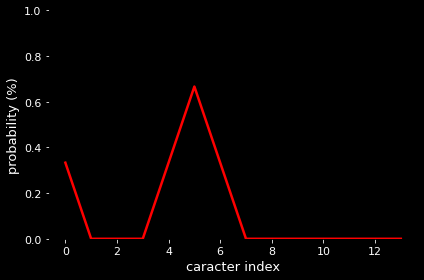

In [8]:
probability = 1. - partial_matrix[-1, 1:] / len(hypothesis)
plot(probability, ylim = (0, 1), xlabel = "caracter index", ylabel = "probability (%)")